# 05 Model Comparison: Transformer vs. LSTM
#
# Funktion:
# Dieses Notebook vergleicht die Performance des Transformer-Modells mit dem LSTM-Modell.
# Es lädt automatisch die Ergebnisse des neuesten LSTM-Runs und stellt sie den aktuellen Transformer-Ergebnissen gegenüber.
#
# Vergleichsbasis:
# - Test-Zeitraum: 2025-01-01 bis 2025-12-31
# - Daten: Identische Features & Zeitreihen (aus dem LSTM-Datenverzeichnis)
# - Metriken: Accuracy, Balanced Accuracy, ROC AUC, MCC


In [1]:
# === IMPORTS ===
# Standard Data Science Stack und PyTorch
import torch
import pandas as pd
import numpy as np
import json
import pickle
import sys
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Metriken für den Vergleich
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score

# Modell-Klasse importieren, um Transformer-Gewichte laden zu können
ROOT = Path("..").resolve()
sys.path.append(str(ROOT))
from finance_transformer.model import TimeSeriesTransformer

print("Libraries loaded.")

Libraries loaded.


In [2]:
# === 1. LSTM ERGEBNISSE LADEN ===
# Wir suchen automatisch den neuesten '_lstm' Ordner im LSTM/results Verzeichnis.
# Das stellt sicher, dass wir immer mit dem aktuellsten Stand vergleichen.

LSTM_RESULTS_ROOT = Path("../../LSTM/results").resolve()
# Glob pattern matched alle Ordner die mit '_lstm' enden. 'sorted(..., key=os.path.getmtime)' sortiert nach Änderungsdatum.
lstm_runs = sorted(glob.glob(str(LSTM_RESULTS_ROOT / "*_lstm")), key=os.path.getmtime)

if not lstm_runs:
    raise FileNotFoundError("Keine LSTM-Ergebnisse gefunden! Bitte zuerst das LSTM trainieren.")

# Den neuesten Ordner auswählen (letztes Element der sortierten Liste)
LATEST_LSTM_DIR = Path(lstm_runs[-1])
print(f"Neuester LSTM Run: {LATEST_LSTM_DIR.name}")

# Evaluations-Ergebnisse (JSON) laden
# Diese Datei wurde vom LSTM-Report-Notebook erstellt und enthält alle Metriken.
with open(LATEST_LSTM_DIR / "evaluation.json", "r") as f:
    lstm_data = json.load(f)

# Wir interessieren uns nur für die Test-Metriken (Out-of-Sample Performance)
lstm_metrics = lstm_data["metrics"]["test"]
print("LSTM Metriken geladen.")

Neuester LSTM Run: 2026-01-07_21-29-55_lstm
LSTM Metriken geladen.


In [3]:
# === 2. TRANSFORMER DATEN & MODELL LADEN ===
# Wir laden die Konfiguration, den Scaler und das trainierte Modell des Transformers.

TRANS_RES_DIR = ROOT / "results"

# Transformer-Config laden (enthält Hyperparameter wie d_model, nhead, seq_len)
with open(TRANS_RES_DIR / "config.json", "r") as f:
    cfg = json.load(f)["cfg"]

# Scaler und Feature-Spalten laden (vom Training)
with open(TRANS_RES_DIR / "scaler.pkl", "rb") as f:
    sc_data = pickle.load(f)
    scaler = sc_data["scaler"]
    feat_cols = sc_data["feat_cols"]

# Daten laden (vom Shared Path = LSTM Daten)
# Das garantiert, dass wir dieselben Daten verwenden.
DATA_PATH = Path("../../LSTM/data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv").resolve()
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
df = df.dropna()

# Wir brauchen nur Daten ab 2024 (für Lookback) und 2025 (für den Test)
# Dies spart Speicher und Rechenzeit.
df = df[df.index >= "2024-01-01"]

# Features extrahieren und skalieren
X_raw = df[feat_cols]
X_scaled = scaler.transform(X_raw).astype("float32")
y_raw = df["target"].values

print(f"Transformer Daten geladen: {len(df)} Zeilen.")

# Modell initialisieren
# Wir müssen die Architektur exakt so aufbauen wie beim Training.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TimeSeriesTransformer(
    in_features=len(feat_cols), 
    d_model=cfg["d_model"], 
    nhead=cfg["nhead"], 
    num_layers=cfg["num_layers"], 
    dim_ff=cfg["dim_ff"], 
    dropout=cfg["dropout"]
).to(device)

# Gewichte laden
# 'map_location' verhindert Fehler, wenn auf GPU trainiert aber auf CPU evaluiert wird (oder umgekehrt).
model.load_state_dict(torch.load(TRANS_RES_DIR / "model.pt", map_location=device))
model.eval() # Dropouts deaktivieren
print("Transformer Modell geladen.")

Transformer Daten geladen: 502 Zeilen.
Transformer Modell geladen.


c:\Users\jacin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [4]:
# === 3. EVALUATION DURCHFÜHREN (2025) ===
# Wir berechnen die Metriken für den Transformer live auf dem Testset.
# Dies dient als doppelte Absicherung, dass die Werte aktuell sind.

preds, gts = [], []
idx = df.index

# Testzeitraum definieren
test_mask = (idx >= "2025-01-01") & (idx <= "2025-12-31")
seq_len = cfg["seq_len"]

print("Evaluiere Transformer auf Test-Set...")

with torch.no_grad(): # Gradienten ausschalten
    for i in range(len(df)):
        # Nur Testdaten, und genügend Historie muss vorhanden sein
        if not test_mask[i] or i < seq_len: continue
        
        # Window extrahieren: [t-seq_len : t]
        window = X_scaled[i-seq_len : i]
        x_in = torch.tensor(window).unsqueeze(0).to(device) # Batch-Dimension hinzufügen
        
        # Vorhersage
        logit = model(x_in).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
        
        preds.append(prob)
        gts.append(y_raw[i])

y_true = np.array(gts)
y_prob = np.array(preds)
# Hard Predictions (Klasse 0 oder 1) bei Threshold 0.5
y_pred = (y_prob > 0.5).astype(int)

# Wir speichern die Metriken in einem Dictionary für den direkten Vergleich
trans_metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "roc_auc": roc_auc_score(y_true, y_prob),
    "mcc": matthews_corrcoef(y_true, y_pred)
}

print("Evaluation abgeschlossen.")

Evaluiere Transformer auf Test-Set...
Evaluation abgeschlossen.


Vergleichstabelle:


,Metric,LSTM,Transformer,Diff (Tr - LSTM)
0,Accuracy,0.5236,0.5160,-0.0076
1,Balanced Acc,0.5162,0.5163,0.0001
2,ROC AUC,0.4987,0.5175,0.0188
3,MCC,0.0354,0.0327,-0.0027


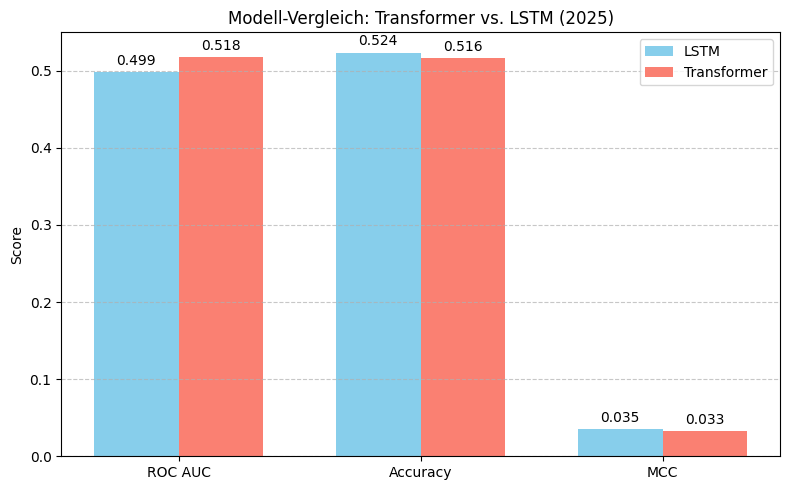

In [5]:
# === 4. VERGLEICH & VISUALISIERUNG ===
# Hier stellen wir die Ergebnisse gegenüber.

# DataFrame erstellen für tabellarische Ansicht
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Balanced Acc", "ROC AUC", "MCC"],
    "LSTM": [
        lstm_metrics["report"]["accuracy"], # Zugriffspfad kann je nach JSON-Struktur variieren
        lstm_metrics["balanced_accuracy"],
        lstm_metrics["roc_auc"],
        lstm_metrics["mcc"]
    ],
    "Transformer": [
        trans_metrics["accuracy"],
        trans_metrics["balanced_accuracy"],
        trans_metrics["roc_auc"],
        trans_metrics["mcc"]
    ]
})

# Differenz berechnen (Positiv = Transformer ist besser, Negativ = LSTM ist besser)
comparison["Diff (Tr - LSTM)"] = comparison["Transformer"] - comparison["LSTM"]

# Tabelle anzeigen
print("Vergleichstabelle:")
display(comparison.round(4))

# Balkendiagramm zur Visualisierung
# Wir plotten die wichtigsten 3 Metriken nebeneinander
metrics = ["ROC AUC", "Accuracy", "MCC"]
x = np.arange(len(metrics))
width = 0.35

# Daten für den Plot extrahieren
vals_lstm = [lstm_metrics["roc_auc"], lstm_metrics["report"]["accuracy"], lstm_metrics["mcc"]]
vals_trans = [trans_metrics["roc_auc"], trans_metrics["accuracy"], trans_metrics["mcc"]]

fig, ax = plt.subplots(figsize=(8, 5))
# Balken zeichnen
rects1 = ax.bar(x - width/2, vals_lstm, width, label='LSTM', color='skyblue')
rects2 = ax.bar(x + width/2, vals_trans, width, label='Transformer', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Modell-Vergleich: Transformer vs. LSTM (2025)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Werte direkt an die Balken schreiben (für bessere Lesbarkeit)
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

plt.tight_layout()

# Plot speichern für den Report
plt.savefig(TRANS_RES_DIR / "model_comparison.png")
plt.show()